# Multi-parameter calibration of the OpenCL RAMP model using ABC

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The <ins>location</ins> and <ins>individual</ins> hazards, and the current risk beta rating must be calibrated to find the values which best reproduce real life observations. Here, the parameter values are calibrated once using historical data and Approximate Bayesian Computation (ABC). 

Prior distributions for each parameter are defined and then ABC approximates the likelihoods of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. 

In this script, the predictive model is calibrated once. The model is ran using ABC for 105 days, with two populations.  


### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       


<ins> Other hazards</ins> 
- `current_risk_beta`  

<!-- To adapt an ABM to allow it to be optimised in response to data emerging in real time. This would mean performing dynamic calibration (i.e. re calibrating at every model time step) using ABC. -->

<!-- At the moment, however, such predictive ABMs are generally calibrated once, using historical data to adjust their more flexible parameters such that the model predicts present and past conditions well. The models are then allowed to roll forward in time, independent of the world, to make a prediction. As the systems modelled are usually complex, it is likely that over longer time periods such models diverge from realistic estimates. Even over shorter time periods there is little done to check model performance, let alone constrain it. -->




## Import modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import cm

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Setup

Read parameters

In [2]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "


Open snapshot (i.e. an already-initialised model)

In [3]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

#### Read in observation data

In [ ]:
## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Add column with cumulative sums rather than cases per week
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_weekly = cases_devon_weekly['CumulativeCases'].values

In [55]:
# Read in daily devon case data (interpolated from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Add column with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()
# Keep just cumulative cases
cases_devon_daily = cases_devon_daily['CumulativeCases'].values

In [56]:
# Convert this interpolated data used in seeding back to weekly
# List the index matching the end day of each week (e.g. 7, 14, 21 etc (minus 1 for indexing starting at 0)
n_days = len(cases_devon_daily)
week_end_days = list(range(6,n_days+1,7))

# Keep only the values from the end of each week
cases_devon_daily_summed_weekly = cases_devon_daily[week_end_days]

### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model, i.e. using the parameter values specified in the parameters file

In [5]:
# ### Run default (manually calibrated) model
# This shows what happens with the 'default' (manually calibrated) model
ITERATIONS = 28  # Number of iterations to run for (must be multiple of 7)
NUM_SEED_DAYS =7   # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(iterations = ITERATIONS, repetitions = REPETITIONS, observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP, use_gpu = USE_GPU, store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE, opencl_dir = OPENCL_DIR, snapshot_filepath = SNAPSHOT_FILEPATH, 
    num_seed_days = NUM_SEED_DAYS)

In [6]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True, quiet = False)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


In [7]:
best_params = {'retail': 0.5234169902075426, 'primary_school': 0.8189852636000965, 'secondary_school': 1.1516441210574122, 
               'work': 0.07179707294863724, 'presymptomatic': 0.3870375860336805, 'symptomatic': 0.6581503001512558, 
               'asymptomatic': 0.2609686051991401, 'current_risk_beta': 0.01786588871820107}
const_params_dict = {"home": 1.0}
OpenCLRunner.set_constants(const_params_dict)

## Run model with these best parameters
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_mc2, sim_mc2, obs_mc2, out_params_mc2, summaries_mc2) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.81s/it]


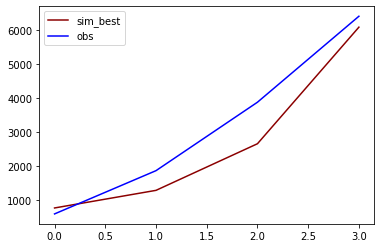

In [8]:
# Check the model returns the observations correctly
# i.e. that theyre the same length
np.array_equal(obs0, cases_devon_daily.loc[:len(sim0)-1,"CumulativeCases"])

# Plot
fig, ax = plt.subplots(1,1)
x = range(len(sim_mc2))
# ax.plot(x, sim0, label="sim", color="orange")
ax.plot(x, sim_mc2, label="sim_best", color="darkred")
ax.plot(x, obs_mc2, label="obs", color="blue")
ax.legend()

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Distance

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [9]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(obs["data"],sim["data"])
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


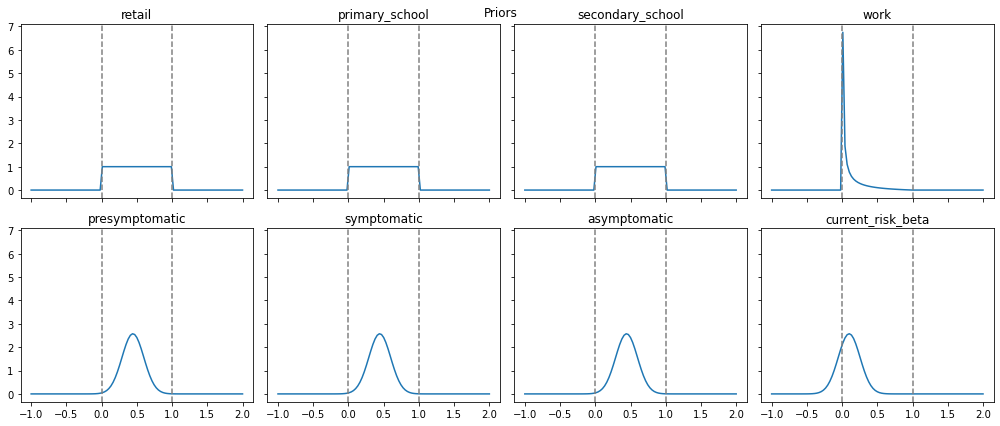

In [10]:
# Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_)
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0 })

# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
# home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([0.03], [1.0])) for _ in range(2) )
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = { "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv, 
    "current_risk_beta":current_risk_beta_rv}

# Plot prior distributions
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
fig.tight_layout()
fig.suptitle("Priors")
fig.show()

In [11]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution( retail = retail_rv, primary_school = primary_school_rv, secondary_school = secondary_school_rv,
    work = work_rv, presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0), symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0), current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0))

### Initialise the ABC algorithm.

In [12]:
# Create path to database in which to store results
db_path = ("sqlite:///" + os.path.join(".", "InitialModelCalibration.db"))
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler())  # Single core because the model is parallelised
# Define observations to use
y_observed = cases_devon_weekly.loc[:(ITERATIONS/7)-1, "CumulativeCases"].values
# The new method indiciates sarting a new run. It returns a history object, whose id identifies the ABCSMC run in the database. 
# This can be used to load the stored data if we want to continue the run
history = abc.new(db_path, {"data": y_observed}) 
run_id = history.id
print("Run ID:", run_id)

ABC.History INFO: Start <ABCSMC id=19, start_time=2022-03-12 22:40:54>


Run ID: 19


### Run ABC

In [13]:
history = abc.run(max_nr_populations=1)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.33211446e+04.
ABC INFO: Accepted: 100 / 196 = 5.1020e-01, ESS: 1.0000e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=19, duration=1:20:27.245776, end_time=2022-03-13 00:01:21>


### Resume ABC run

In [35]:
# Create a completely new ABCSMC object. We pass the same model, prior and distance from before.
abc_continued = pyabc.ABCSMC(models=OpenCLRunner.run_model_with_params_abc, parameter_priors=priors,
    distance_function=distance, sampler = pyabc.sampler.SingleCoreSampler()) 
# To resume a run, use the load method to load the necessary data. We pass to this method the id of the run we want to continue
abc_continued.load(db_path, run_id)
# run it
abc_continued.run(max_nr_populations=1)

ABC INFO: t: 5, eps: 1.65653892e+03.
ABC INFO: Accepted: 100 / 296 = 3.3784e-01, ESS: 9.8556e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=19, duration=1 day, 14:40:04.899138, end_time=2022-03-14 13:20:59>


#### Check number of populations

In [41]:
history.n_populations

6

### Save ABC model results

In [35]:
# fname = "abc-2_105days_7seeddays_v2.pkl"
# with open( fname, "wb" ) as f:
#         pickle.dump( history, f)

### Algorithm diagnostics

In [59]:
# _, arr_ax = plt.subplots(2, 2)

# pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
# pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
# #pyabc.visualization.plot_credible_intervals(
# #    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
# #    show_mean=True, show_kde_max_1d=True,
# #    refval={'mean': 2.5}, 
# #    arr_ax=arr_ax[1][0])
# pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

# plt.gcf().set_size_inches((12, 8))
# plt.gcf().tight_layout()

### Analyse the posterior parameter distribution

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [15]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,primary_school,retail,secondary_school,symptomatic,work,weight
0,2341,0.602405,0.014288,0.399235,0.382069,0.803941,0.097039,0.413707,0.000182,4.301113e-01
1,2321,0.364587,0.028302,0.706945,0.314606,0.233196,0.159204,0.584656,0.004064,1.202051e-01
2,2409,0.574208,0.005600,0.411578,0.326532,0.730097,0.029227,0.507241,0.155806,8.838531e-02
3,2376,0.759864,0.012286,0.298217,0.648401,0.008697,0.341107,0.376113,0.058003,3.292061e-02
4,2418,0.527390,0.007678,0.456847,0.181233,0.158654,0.493129,0.320243,0.017787,2.786288e-02
...,...,...,...,...,...,...,...,...,...,...
95,2378,0.998851,0.008535,0.403348,0.563021,0.012759,0.696236,0.142510,0.058838,5.418403e-05
96,2419,0.191311,0.037884,0.955674,0.215147,0.198640,0.547628,0.200634,0.029669,4.223435e-05
97,2342,0.269800,0.004932,0.602935,0.893741,0.598172,0.997102,0.031365,0.069626,4.174513e-05
98,2360,0.293257,0.016588,0.951556,0.649477,0.867596,0.426617,0.711035,0.045294,3.102485e-05


#### Plot the marginal posteriors  
The estimates of the optimal values for each parameter individually

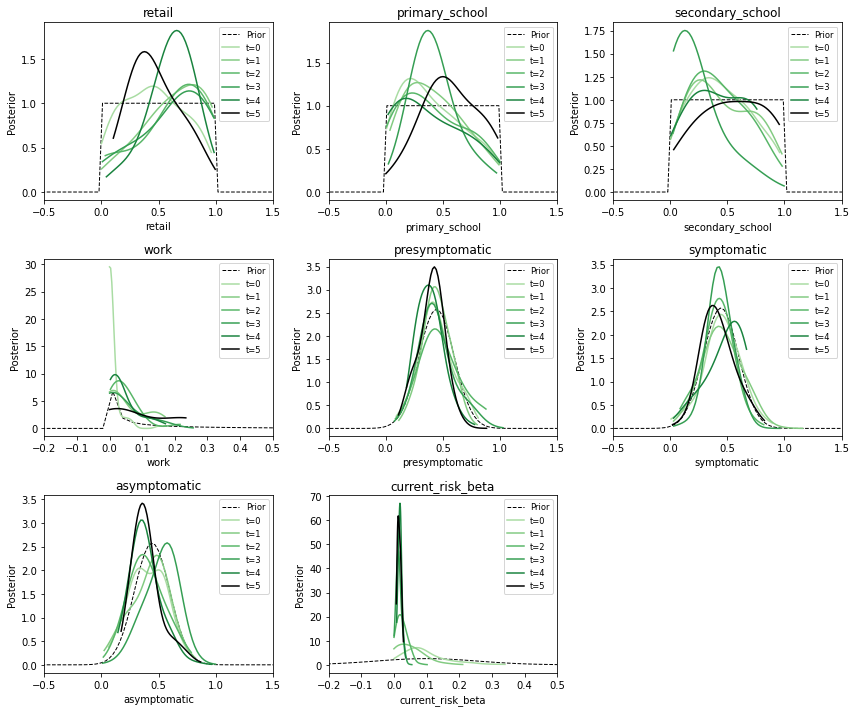

In [42]:
fig, axes = plt.subplots(3,3, figsize=(12,10))
# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 7)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    # Add distributions
    for t in range(history.max_t + 1):
        color = colors[t]
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"t={t}", 
            #alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= 'black' if t==history.max_t else color) # Make the last one black
        if param!="work":
            ax.set_xlim(-0.5,1.5)
        if param =='work':
             ax.set_xlim(-0.2,0.5)          
        if param =='current_risk_beta':
             ax.set_xlim(-0.2,0.5)                   
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
axes[2,2].set_axis_off()        
fig.tight_layout()

In [ ]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


### Analyse the model predictions within each ABC calibration population

#### Store predictions and distances for each particle in each population 

In [43]:
# Create dictionary to store results for each population
abc_sum_stats = {}

# Loop through each population
for t in range(0,history.max_t+1):
    # Create lists to store values for each particle
    data_daily_l = []
    distances_l = []

    # Get the summary stats for this population
    # ([1] means keep just the dataframe and not the array of weights)
    weighted_sum_stats = history.get_weighted_sum_stats_for_model(t=t)[1]

    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats[particle_no]
        # Get daily predictions
        data_daily = particle_x_dict["data_daily"]     
        # Add daily msoa predictions for this particle to list
        data_daily_l.append(data_daily)
        
        # Add distances to list
        distances_l.append(particle_x_dict['distance'])
    
    # Add lists to dictionaries    
    abc_sum_stats["t{}_distances".format(t)] = distances_l
    abc_sum_stats["t{}_dailydata".format(t)] = data_daily_l


#### Create plot of daily cumulative infections with one subplot per population and one line per particle

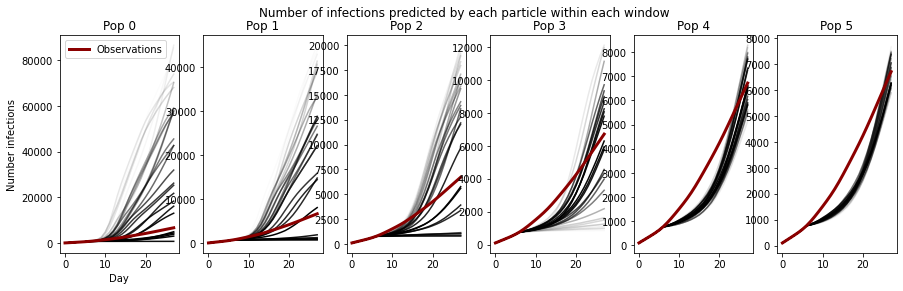

In [70]:
# Create figure
fig, axes = plt.subplots(1, 6, figsize=(15,4))
axes_number = 0
for t in range(0,history.max_t+1):
        
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]
    
    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
        
    x = range(0,len(data_daily_l[i])) 
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(data_daily_l[i])):
        axes[axes_number].plot(x, data_daily_l[i],color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)

    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(data_daily_l[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_title("Pop {}".format(t))
    axes[0].set_xlabel("Day")

    # Set full plot title
    fig.suptitle('Number of infections predicted by each particle within each window')
    
    axes_number =axes_number +1
   

axes[0].set_ylabel("Number infections")
axes[0].legend(fontsize="medium")

#### Create plot of daily cumulative infections with one subplot per population and the line showing the predictions of the best performing particle

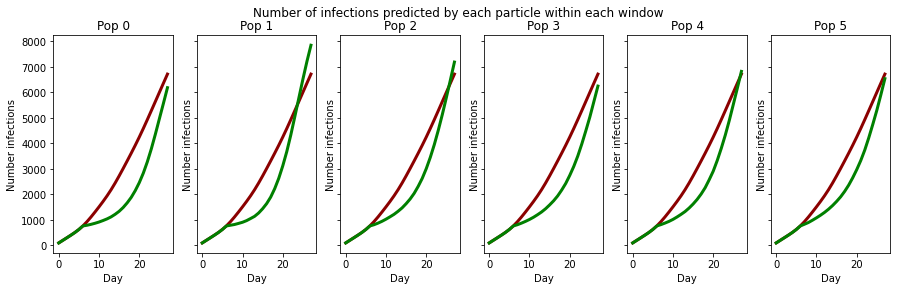

In [68]:
# Create figure
fig, axes = plt.subplots(1, 6, figsize=(15,4), sharey= True)
axes_number = 0
for t in range(0,history.max_t+1):
        
    data_daily_l = abc_sum_stats["t{}_dailydata".format(t)]
    distance_l = abc_sum_stats["t{}_distances".format(t)]

    # Find the best particle
    best_particle_idx = distance_l.index(min(distance_l))
        
    # Add observations
    axes[axes_number].plot(x, cases_devon_daily[0:len(data_daily_l[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Add the best particle
    axes[axes_number].plot(x, data_daily_l[best_particle_idx], color="green", linewidth = 3,
                          label = 'Best particle')  # (1-x because high distance is bad)
    
    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("Pop {}".format(t))

    # Set full plot title
    fig.suptitle('Number of infections predicted by each particle within each window')
    
    axes_number =axes_number +1

### Find the optimal value for Current Risk Beta (and other parameters)
Firstly, fit a distribution to the posterior parameter values from the final population generated by ABC.  
 - For each of the 100 particles in the final population of the model, get the associated weight and value for each parameter
 - Estimate the underlying distribution from which these particles were drawn using KDE
 - Sample X times from this distribution  
 - Use each vector of sampled parameter values to run the model

This captures the uncertainty in the parameter values and in the associated model outputs.  
  
Then, find the vector of sampled parameter values which is associated with the lowest distance value. We can assume this to be the set of parameters that gave the result that was the most likely to have generated the observations. This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).

<!-- And then, find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).-->

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

#### Fit distribution to parameter values from posterior of final population

In [40]:
# Define number of samples
N_samples = 100
# Retrieve information on parameter posteriors
# This returns a dataframe containing the values associated with each parameter for each of the 100 particles
# in the last availalbe population of model m. Also an array of weights associated with each particle.
df, w = history.get_distribution(m=0, t=history.max_t)

# Fit a KDE to the posterior to allow new parameters to be proposed based on the current population
# Use KDE to estimate the underlying probability distribution that generated the datasets df, w
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)

Finished sampling. Ignored 70 negative samples.


#### Sample from this distribution N times and run the model with each parameter vector

In [ ]:
# Take X samples from this new distribution
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
distance_l = []  # Distance values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
#         print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = {param: sample[str(param)] for param in priors}

    # Run the model
    (_distance, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
#     print(f"Distance: {_distance}.")

    distance_l.append(_distance)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

#### Plot each sample's predicted infections 
The darker the line, the higher the distance of the sample

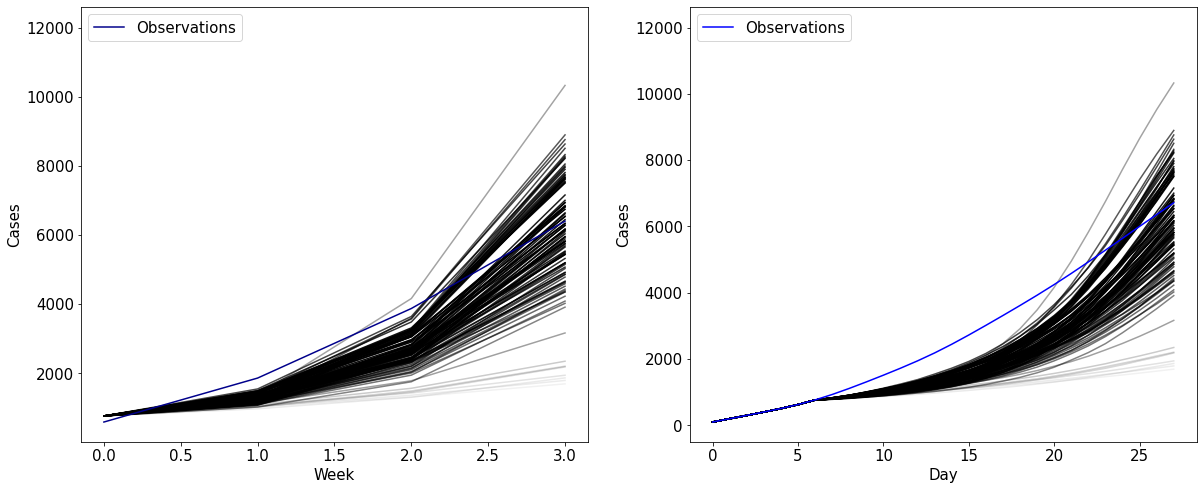

In [46]:
# Normalise distance to 0-1 to calculate transparency
_distance = np.array(distance_l)  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - distance_norm[i])  # (1-x because high distance is bad)
# Plot observations
ax1.plot(x, obs_l[0], label="Observations", color="darkblue")
# Plot result from manually calibrated model
# ax1.plot(x, sim0, label="Initial sim", color="orange")
# Format
ax1.legend(fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)
# ax1.set_ylim(0,90000)

############## PLOT DAILY DATA 
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            color="black", alpha=1 - distance_norm[i])  # (1-x because high distance is bad)
# Plot observations
ax2.plot(x, cases_devon_daily[0:ITERATIONS], label="Observations", color="blue")
# # Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)
# ax2.set_ylim(0,90000)
plt.show()

del _distance, distance_norm


Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

In [ ]:
# # Weekly

# #best_paramswo long arrays with every result from every particle
# x = list(range(len(sim_l[0])))  # List of iteration numbers (i.e week numbers)
# X = []
# for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
#     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# X = np.array(X)
# y = []
# for i in range(len(summaries_l)):
#     y += list(sim_l[i])
# y = np.array(y)

# # Generate the GAM
# gam = LinearGAM( n_splines=250)
# #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# gam.gridsearch(X, y)
# #XX = gam.generate_X_grid(term=0, n=len(X))
# XX = gam.generate_X_grid(term=0)

# # Plot
# fig, ax = plt.subplots(1,1, figsize=(12,8))

# ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# #pdep, confi = gam.partial_dependence(term=0, width=.95)
# #ax.plot(XX, pdep)
# #ax.plot(XX, confi, c='r', ls='--')

# ax.plot(x, obs_l[0], label="Observations", color="blue")
# ax.plot(x, sim0, label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('95% prediction interval');


# # ## Daily??

# # #best_paramswo long arrays with every result from every particle
# # x = list(range(len(sim_l[0])*7))  # List of iteration numbers (i.e week numbers)
# # X = []
# # for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
# #     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# # X = np.array(X)
# # y = []
# # for i in range(len(summaries_l)):
# #     y +=  list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
# # y = np.array(y)

# # # Generate the GAM
# # gam = LinearGAM( n_splines=250)
# # #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# # gam.gridsearch(X, y)
# # #XX = gam.generate_X_grid(term=0, n=len(X))
# # XX = gam.generate_X_grid(term=0)


# # # Plot
# # fig, ax = plt.subplots(1,1, figsize=(12,8))

# # ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# # ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# # #pdep, confi = gam.partial_dependence(term=0, width=.95)
# # #ax.plot(XX, pdep)
# # #ax.plot(XX, confi, c='r', ls='--')

# # ax.plot(x, cases_devon_daily[0:105], label="Observations", color="blue")
# # ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.legend()
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.set_title('95% prediction interval');



Do a KDE plot with a logarithmic colour scale.

In [49]:
# # # Do a KDE plot with a logarithmic colour scale.
# # from matplotlib.colors import LogNorm
# # fig, ax = plt.subplots(1,1, figsize=(10,7))
# # h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# # ax.set_xlabel("Iteration")
# # ax.set_ylabel("Cumulative cases")

# # ax.plot(x, obs_l[0], label="Observations", color="blue")
# # ax.plot(x, sim0, label="Initial sim", color="orange")
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.legend()
# # fig.colorbar(h[3], ax=ax)
# # #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# # ax.set_title('Density plot of results posterior');

# #Do a KDE plot with a logarithmic colour scale.
# from matplotlib.colors import LogNorm
# fig, ax = plt.subplots(1,1, figsize=(10,7))
# h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# ax.set_xlabel("Iteration")
# ax.set_ylabel("Cumulative cases")

# ax.plot(x,cases_devon_daily[0:105], label="Observations", color="blue")
# ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# fig.colorbar(h[3], ax=ax)
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('Density plot of results posterior');

#### Find the best performing parameter vector

<!-- Find the parameter modes

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_ -->

In [47]:
# Find the index of the sample with the lowest distance value
best_model_idx = np.argmin(distance_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'retail': 0.23978745645261162, 'primary_school': 0.3264949182903791, 'secondary_school': 0.946802493933189, 'work': 0.3440032482663221, 'presymptomatic': 0.4747727816429057, 'symptomatic': 0.21357031459565134, 'asymptomatic': 0.42350167034023556, 'current_risk_beta': 0.008793952998065336}


#### See how the 'best performing' parameter values relate to the marginal posteriors

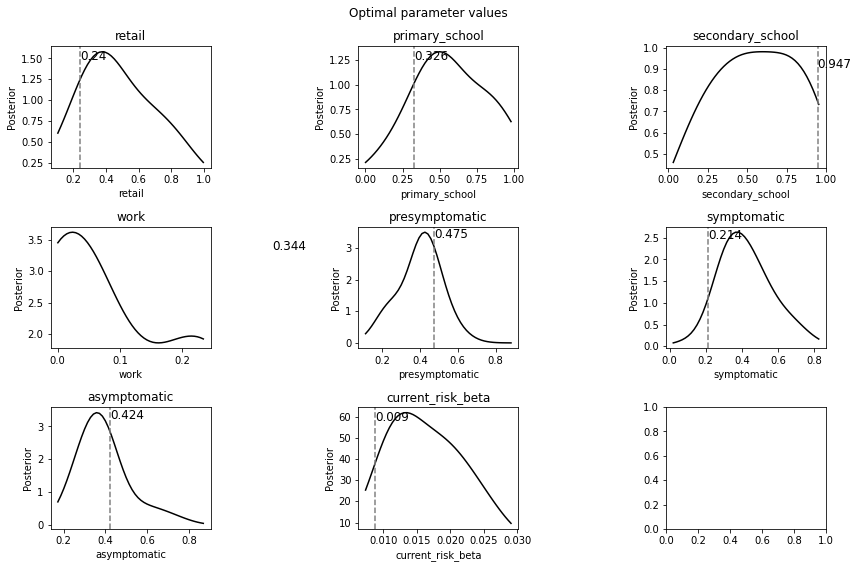

In [48]:
fig, axes = plt.subplots(3,3, figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    #ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

#### Run the model with the 'best performing' parameter values

In [49]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bp, sim_bp, obs_bp, out_params_bp, summaries_bp) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True, quiet = False)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.52s/it]


#### Plot the results

Text(0, 0.5, 'Cases')

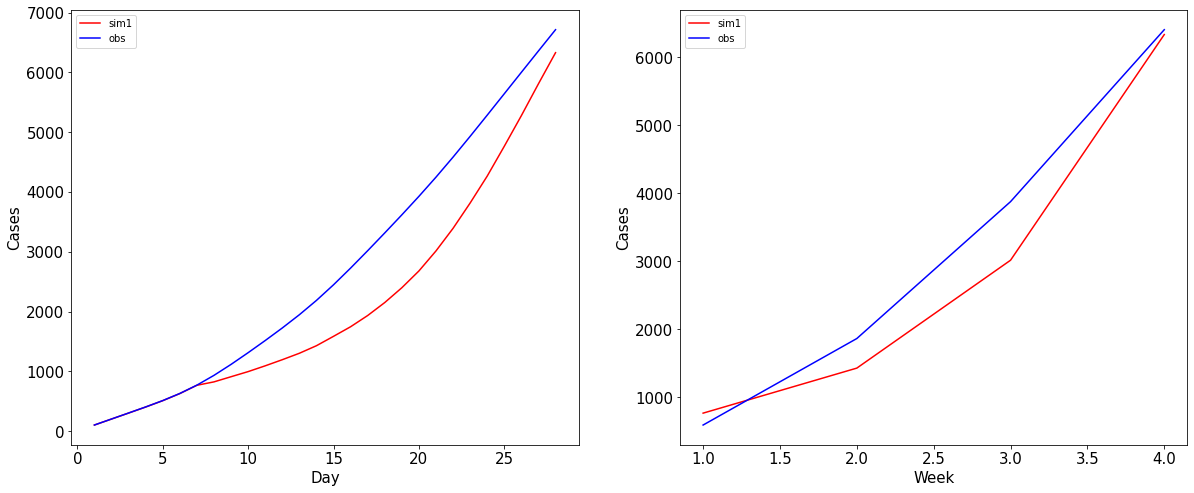

In [53]:
# Create figure
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

##### daily data
x = range(1, len(OpenCLRunner.get_cumulative_new_infections(summaries_bp))+1)
ax1.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_bp), label="sim1", color="red")
ax1.plot(x, cases_devon_daily[0:len(OpenCLRunner.get_cumulative_new_infections(summaries_bp))], label="obs", color="blue")
ax1.legend()
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Day", size=15)
ax1.set_ylabel("Cases",size=15)

###### weekly data
x = range(1, len(sim_bp)+1)
ax2.plot(x, sim_bp, label="sim1", color="red")
ax2.plot(x, obs_bp, label="obs", color="blue")
ax2.legend()
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Week", size=15)
ax2.set_ylabel("Cases",size=15)        

## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

In [32]:
# # Function to plot disease status by MSOA for a given timestep and status
# def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
#     """
#     """
#     # Summary can be a single summary, or a list of a few summaries (will need an average)
#     # get dataframes for all statuses
#     msoa_data = summary.get_area_dataframes()
    
#     msoa_data_for_status = msoa_data[disease_status]

#     # add "Code" column so dataframes can be merged
#     msoa_data_for_status["Code"] = msoa_data_for_status.index
#     msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

#     msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

# ## Load required data
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# gis_data_dir = ("../../devon_data")
# osm_buildings = load_osm_shapefile(gis_data_dir)
# devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)    
    

# N=len(summaries_bp)
# disease_status = "exposed"

# fig, axes = plt.subplots(nrows=2, ncols=int(N/2)+1,
#                     figsize=(12,8))

# for i in range(N):
#     #idx = indices[i]
#     ax = axes.flat[i]
#     plot_msoa_choropleth(devon_msoa_shapes, summaries_bp[i], disease_status, 99, ax=ax)
#     ax.set_title(f"Run {i}")